# Predicting House Prices with the Ames Dataset


The dataset I use, `AmesHousing.txt` is slightly different from the dataset that can be found on Kaggle.
For instance the column names here have spaces, unlike the set from Kaggle. 
I had to slightly modify the program for it to fit the Kaggle dataset.

- At this time (with the simple linear regression) I have a score of 0.13356 on the Kaggle public leaderboard.
- UPDATE: my current score is 0.12613, using Ridge and feature scaling.
- UPDATE 2: score of 0.12538 using Lasso and feature scaling: Lasso performs better in the public score but is slightly less efficient here.
- UPDATE 3: I now have a score of 0.12355 by averaging Lasso, GradientBoosting, ElasticNet and LightGBM models.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

data = pd.read_csv('AmesHousing.txt', delimiter='\t')
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [7]:
data.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

## The 'SalePrice' column

In [8]:
data['SalePrice'].describe()

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

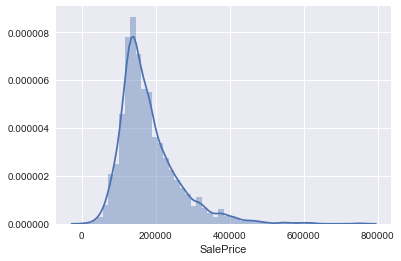

In [9]:
# histogram
sns.distplot(data['SalePrice'])

In [10]:
print('Skew: %f' % data['SalePrice'].skew())
print('Kurtosis: %f' % data['SalePrice'].kurt())

Skew: 1.743500
Kurtosis: 5.118900


We might try later to transform the Sale Price column into a normal distribution by taking the log of the column.

## Outliers

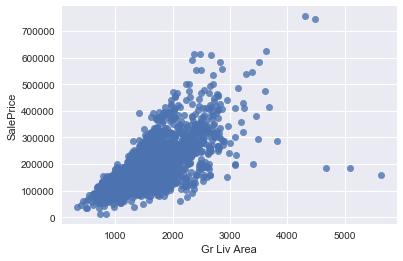

In [11]:
sns.regplot(data['Gr Liv Area'],data['SalePrice'],fit_reg=False)
plt.show()

We can see 5 big outliers at the right of the graph that need to be deleted. According to the dataset documentation, and as it can be seen on the graph, removing any houses with more than 4000 square feet from the dataset will take care of those unusual values. 

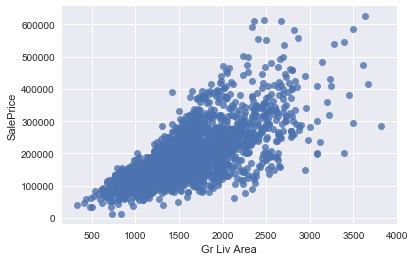

In [12]:
data = data[data['Gr Liv Area'] < 4000]
sns.regplot(data['Gr Liv Area'],data['SalePrice'],fit_reg=False)
plt.show()

## Correlation matrix

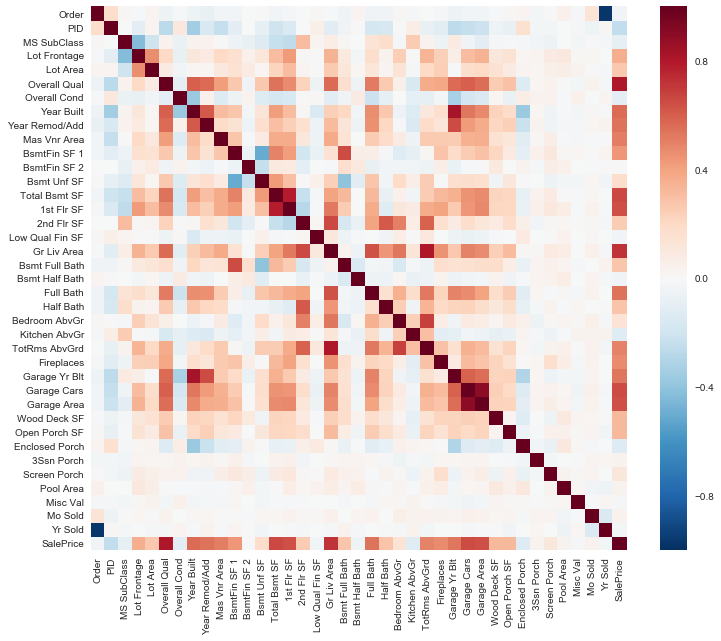

In [13]:
corr = data.corr()
fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(corr)
plt.show()

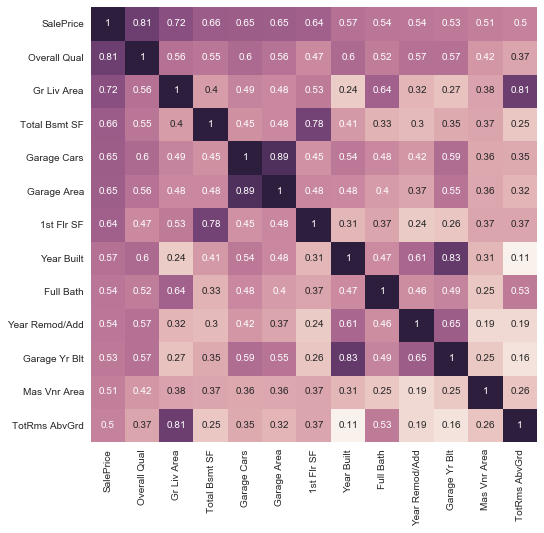

In [14]:
cols = corr.nlargest(13,'SalePrice')['SalePrice'].index
data2 = data[cols]
corr2 = data2.corr()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr2,cbar=False,annot=True)
plt.show()

We can safely delete the 'Garage Cars', 'Total Bsmt SF' and 'TotRms AbvGrd' columns because of their colinearity with 'Garage Area', '1st Flr SF' and 'Gr Liv Area' respectively. They roughly give the same information. I'm keeping Garage Area because it is a continuous variable, same for Gr Liv Area.

In [15]:
data.drop(['Garage Cars','Total Bsmt SF','TotRms AbvGrd'],axis=1,inplace=True)

## Missing Data

In [16]:
null_count = data.isnull().sum()
null_count.sort(ascending=False)
missing_rate = pd.concat([null_count,(null_count/data.shape[0])*100],axis=1)
missing_rate.head(27)

,0,1
Pool QC,2914,99.623932
Misc Feature,2820,96.410256
Alley,2727,93.230769
Fence,2354,80.478632
Fireplace Qu,1422,48.615385
Lot Frontage,490,16.752137
Garage Cond,159,5.435897
Garage Qual,159,5.435897
Garage Yr Blt,159,5.435897
Garage Finish,159,5.435897


We can set our threshold to 10% of missing values so the first six features will be deleted. Apart from 'Pool QC', the five first features seems useless, and 'Pool QC' has only 11 entries.
We also have to deal with all the remaining missing values. Before replacing them by a value such as the mean of the column, we can read the documentation to see if those features are useful or not, and use boxplots to confirm or not.

Garage features:

- We can replace the only missing value in Garage Area by 0, as a missing value indicates no garage.
- We can delete the Garage Type column, as well as Garage Cond and Garage Qual. The two last features can seem useful at first, but a boxplot shows that it is more complicated, and that we better delete them.
- I'm going to keep Garage Finish, as the boxplot with SalePrice shows that the price goes higher if the garage is finished.
- We're going to keep Garage Yr Built for now, as the correlation with SalePrice is quite high

Basement features:

- I'm keeping Bsmt Exposure, Bsmt Qual and Bsmt Cond, as they seem to be useful
- I'm deleting all BsmtFin columns, as well as Bsmt Unf SF, and Bsmt Full Bath and Bsmt Half Bath.

Other features:

- For now, I will keep Mas Vnr Area, and delete Mas Vnr Type
- I'm also keeping the Electrical column as only one value is missing, and I'm going to delete the corresponding row

In [17]:
data['Garage Area'] = data['Garage Area'].fillna(0)
data.drop(['Order','Pool QC','Misc Feature','Alley','Fence','Fireplace Qu','Lot Frontage','Garage Type','Garage Cond','Garage Qual','BsmtFin SF 1','BsmtFin SF 2','BsmtFin Type 1','Mas Vnr Type','BsmtFin Type 2','Bsmt Unf SF','Bsmt Full Bath','Bsmt Half Bath'],inplace=True,axis=1)

I delete the Order column, which is a useless ID column, and the PID one, because I couldn't find any information about it.

In [18]:
data.dropna(subset=['Electrical'],inplace=True)

In [19]:
# we're filling the remaining missing values with 'None' or 0, depending on the type of values
for col in ['Garage Finish','Bsmt Exposure','Bsmt Cond','Bsmt Qual']:
    data[col] = data[col].fillna('None')
for col in ['Garage Yr Blt','Mas Vnr Area']:
    data[col] = data[col].fillna(0)

In [20]:
# verifying if missing values are all gone
null_count = data.isnull().sum()
null_count.sum()

0

There's no missing value left

In [21]:
data.columns

Index(['PID', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Street', 'Lot Shape',
       'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'Functional', 'Fireplaces',
       'Garage Yr Blt', 'Garage Finish', 'Garage Area', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
       'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold',
       'Sale Type', 'Sale Condition', 'SalePrice'],
      dtype='object'

In [22]:
len(data.columns)

61

## Dummy Variables

In [23]:
data = pd.get_dummies(data)
len(data.columns)

247

# Model implementation
## Basic Linear Regression

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

features = data.drop('SalePrice',axis=1).columns
target = 'SalePrice'

folds = 8
lr = LinearRegression()
kf = KFold(folds, shuffle=True, random_state = 1)
mses = cross_val_score(lr, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
rmses = [np.sqrt(abs(mse)) for mse in mses]

print('RMSES: ')
print(rmses)
print('\nAverage RMSE: %.1f' % np.mean(rmses))

RMSES: 
[22024.068750940693, 23783.274264677078, 24829.515016930993, 21125.640107546595, 22894.940900284819, 21413.172148408532, 26551.365988073798, 27191.79926150852]

Average RMSE: 23726.7


I think that an average RMSE of 23726 is quite good for the first basic model, but we can do better.
As we've seen in the beginning, the distribution of the SalePrice column is not normal, with positive skewness and high kurtosis, so it is not ideal for linear regression. To correct that, we can just take the log of the column.

In [25]:
data['SalePrice'] = np.log(data['SalePrice'])

In [26]:
mses = cross_val_score(lr, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
rmses = [np.sqrt(abs(mse)) for mse in mses]

print('RMSLES: ')
print(rmses)
print('\nAverage RMSLE: %.5f' % np.mean(rmses))

RMSLES: 
[0.11009283994512652, 0.1560621550897085, 0.16741496993574168, 0.12263915503356507, 0.10591581936000551, 0.130370066140959, 0.13589846202595574, 0.11921489156838504]

Average RMSLE: 0.13095


In [27]:
# Gr Liv Area column
print('Skew: %f' % data['Gr Liv Area'].skew())
print('Kurtosis: %f' % data['Gr Liv Area'].kurt())

Skew: 0.878540
Kurtosis: 1.070835


Considering those values, let's do the same log transformation to the Gr Liv Area column:

In [28]:
data['Gr Liv Area'] = np.log(data['Gr Liv Area'])

In [29]:
mses = cross_val_score(lr, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
rmses = [np.sqrt(abs(mse)) for mse in mses]

print('RMSLES: ')
print(rmses)
print('\nAverage RMSLE: %.5f' % np.mean(rmses))

RMSLES: 
[0.10742391568322592, 0.15508719878035993, 0.16485904491413764, 0.1204580639701653, 0.10585762738962774, 0.12538381637779816, 0.131540968928121, 0.11743765637634231]

Average RMSLE: 0.12851


In [30]:
print('Skew: %f' % data['1st Flr SF'].skew())
print('Kurtosis: %f' % data['1st Flr SF'].kurt())

Skew: 0.942324
Kurtosis: 1.662111


Same thing for the 1st Flr SF:

In [31]:
data['1st Flr SF'] = np.log(data['1st Flr SF'])

In [32]:
mses = cross_val_score(lr, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
rmses = [np.sqrt(abs(mse)) for mse in mses]

mean = np.mean(rmses)

print('RMSLES: ')
print(rmses)
print('\nAverage RMSLE: %.5f' % mean)

RMSLES: 
[0.1071919023975727, 0.15526868400334479, 0.16188387826396344, 0.12034049596929164, 0.1058779826445711, 0.12472428661961225, 0.12931664523888792, 0.11654506341531631]

Average RMSLE: 0.12764


## Using Regularization with Lasso and Ridge regression

We have to select the best value for the parameter alpha, ie. the one that gives us the lowest RMSLE.

In [33]:
from sklearn.linear_model import Lasso

def lasso_alpha(alpha_list):
    folds = 8
    avg_rmses = []
    for alpha in alpha_list:
        lasso = Lasso(alpha=alpha)
        kf = KFold(folds, shuffle=True, random_state = 1)
        mses = cross_val_score(lasso, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
        rmses = [np.sqrt(abs(mse)) for mse in mses]
        mean = np.mean(rmses)
        avg_rmses.append(mean)
        
    return avg_rmses

alpha_list = np.linspace(0.0001,0.001,10)
results = lasso_alpha(alpha_list)

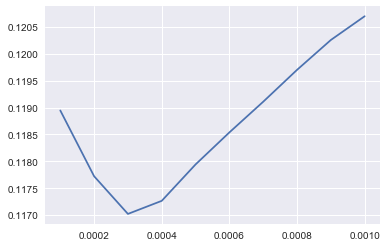

In [34]:
plt.plot(alpha_list,results)
plt.show()

Let's zoom on the alpha values between 0.0002 and 0.0004:

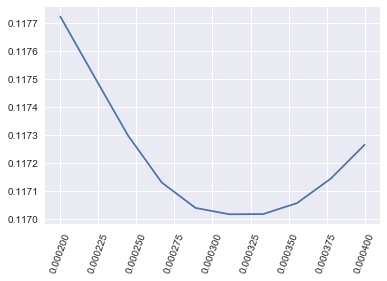

In [35]:
alpha_list = np.linspace(0.0002,0.0004,10)
results = lasso_alpha(alpha_list)
plt.plot(alpha_list,results)
plt.xticks(rotation=70)
plt.show()

Based of this plot, I am going to take alpha = 0.00032.

In [36]:
lasso = Lasso(alpha = 0.00032)

mses = cross_val_score(lasso, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
rmses = [np.sqrt(abs(mse)) for mse in mses]

mean = np.mean(rmses)

print('RMSLES: ')
print(rmses)
print('\nAverage RMSLE with LASSO: %.5f' % mean)

RMSLES: 
[0.10428873488017834, 0.16668900479073709, 0.11585000380951348, 0.12078368644774944, 0.10574496640886485, 0.10521911072392, 0.1074186835344747, 0.11011213394577568]

Average RMSLE with LASSO: 0.11701


Switching from the basic Linear Regression model to a model with regularization such as Lasso resulted as a great improvement : RMSLE of 0.12764 before, and 0.11701 now.

Now let's test the L2-regularization with the Ridge Regression. This models, contrary to Lasso, does not set any coefficient to zero, so it keeps all the features.

In [37]:
from sklearn.linear_model import Ridge

def ridge_alpha(alpha_list):
    folds = 8
    avg_rmses = []
    for alpha in alpha_list:
        ridge = Ridge(alpha=alpha)
        kf = KFold(folds, shuffle=True, random_state = 1)
        mses = cross_val_score(ridge, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
        rmses = [np.sqrt(abs(mse)) for mse in mses]
        mean = np.mean(rmses)
        avg_rmses.append(mean)
        
    return avg_rmses

alpha_list = np.linspace(0.5,20,20)
results = ridge_alpha(alpha_list)

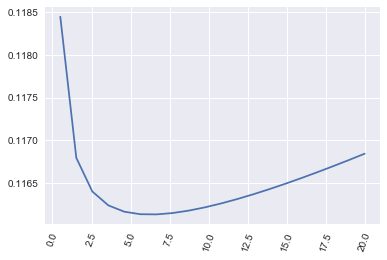

In [38]:
plt.plot(alpha_list,results)
plt.xticks(rotation = 70)
plt.show()

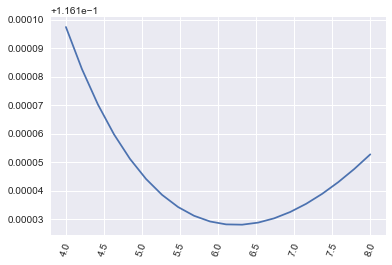

In [39]:
alpha_list = np.linspace(4,8,20)
results = ridge_alpha(alpha_list)
plt.plot(alpha_list,results)
plt.xticks(rotation = 70)
plt.show()

Let's take alpha = 6.3:

In [40]:
r = Ridge(alpha = 6.3)

mses = cross_val_score(r, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
rmses = [np.sqrt(abs(mse)) for mse in mses]

mean = np.mean(rmses)

print('RMSLES: ')
print(rmses)
print('\nAverage RMSLE with RIDGE: %.5f' % mean)

RMSLES: 
[0.10515861972414695, 0.16112210082096415, 0.11491902481262792, 0.1196053772519271, 0.10462148533265955, 0.10810160201954548, 0.10648323285005852, 0.10901227858777343]

Average RMSLE with RIDGE: 0.11613


The result here is slightly better than the Lasso model : 0.11613 vs. 0.11701.

## Feature Scaling
Let's scale values to make it more robust to outliers, with the RobustScaler function.

In [41]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

lasso = make_pipeline(RobustScaler(),Lasso(alpha = 0.00032))

mses = cross_val_score(lasso, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
rmses = [np.sqrt(abs(mse)) for mse in mses]

mean = np.mean(rmses)

print('RMSLES: ')
print(rmses)
print('\nAverage RMSLE with LASSO and ROBUSTSCALER: %.5f' % mean)

RMSLES: 
[0.1044673758621032, 0.16629086141946026, 0.11607101063052001, 0.12036761893547503, 0.1058395360376885, 0.10531604643397624, 0.10749788014159059, 0.10986653165199403]

Average RMSLE with LASSO and ROBUSTSCALER: 0.11696


In [42]:
r = make_pipeline(RobustScaler(),Ridge(alpha = 6.3))

mses = cross_val_score(r, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
rmses = [np.sqrt(abs(mse)) for mse in mses]

mean = np.mean(rmses)

print('RMSLES: ')
print(rmses)
print('\nAverage RMSLE with RIDGE and ROBUSTSCALER: %.5f' % mean)

RMSLES: 
[0.10506054842441312, 0.16063286913914007, 0.11523440046862211, 0.11913597522371995, 0.10493642515842129, 0.10798742068631133, 0.10684138607984515, 0.10878024061610117]

Average RMSLE with RIDGE and ROBUSTSCALER: 0.11608


Feature scaling slightly improves both Lasso and Ridge models.

## Ensemble Models
## Random Forest

In [43]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, min_samples_split=10)
mses = cross_val_score(rf, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
rmses = [np.sqrt(abs(mse)) for mse in mses]

mean = np.mean(rmses)
mean

0.13776608862410511

## Gradient Boosting

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(loss='huber',n_estimators=450, min_samples_split=4, min_samples_leaf=2, max_depth=2)
mses = cross_val_score(gb, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
rmses = [np.sqrt(abs(mse)) for mse in mses]

mean = np.mean(rmses)
mean

0.11757437038552856

## Extra Randomised Trees

In [45]:
from sklearn.ensemble import ExtraTreesRegressor

ext = ExtraTreesRegressor(n_estimators=100, min_samples_split=10)
mses = cross_val_score(ext, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
rmses = [np.sqrt(abs(mse)) for mse in mses]

mean = np.mean(rmses)
mean

0.1338090759225351

## LightGBM

In [72]:
import lightgbm as lgb

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=2000,
                              max_bin = 55, bagging_fraction = 0.85,
                              bagging_freq = 5, feature_fraction = 0.4,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =4, min_sum_hessian_in_leaf = 11)
mses = cross_val_score(model_lgb, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
rmses = [np.sqrt(abs(mse)) for mse in mses]

mean = np.mean(rmses)
mean

0.11607283118308669

Ensemble models performs quite well on this dataset.

## ElasticNet

In [87]:
from sklearn.linear_model import ElasticNet

en = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00035, l1_ratio=0.9, random_state=2))
mses = cross_val_score(en, data[features], data[target], scoring="neg_mean_squared_error", cv=kf)
rmses = [np.sqrt(abs(mse)) for mse in mses]

mean = np.mean(rmses)
mean

0.11690336841734325